In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("usd_inr_daily_raw.csv", parse_dates=["Date"])


In [4]:
df=df.rename(columns={'USD_INR': 'Close'})

In [5]:
df = df.sort_values("Date").set_index("Date")

In [6]:
df

,Close,daily_diff
Date,,
2015-10-27,64.901001,NaN
2015-10-28,65.067001,64.901001
2015-10-29,64.945999,65.067001
2015-10-30,65.444000,64.945999
2015-11-02,65.415001,65.444000
...,...,...
2025-10-20,88.002296,87.990700
2025-10-21,87.879997,88.002296
2025-10-22,88.001602,87.879997


In [7]:
df.isnull().sum()

Close         0
daily_diff    1
dtype: int64

In [8]:
series = df["Close"].asfreq("B")  # business day frequency


means set the time series frequency to “Business Days” (Mon–Fri).

In financial data, the index (e.g., Date column) is often not continuous: weekends and holidays are missing because the market is closed.

By using asfreq("B"), you ensure the series now has a regular daily frequency — one row per business day.
Pandas reindexes the series to include all business days.

Missing dates (like weekends or holidays) get inserted with NaN values.


In [17]:
print(series.isnull().sum())

6


In [9]:
series = series.interpolate(method="time")  


This fills in those NaN values based on time interpolation.

Since the index is a DateTimeIndex, method="time" uses the actual time distance between observations to linearly interpolate missing values.

In other words:

It estimates the “missing” prices for non-trading days smoothly between known data points.

The resulting series is uniformly spaced and free of gaps, which many time-series models (ARIMA, LSTM, Prophet, etc.) require.

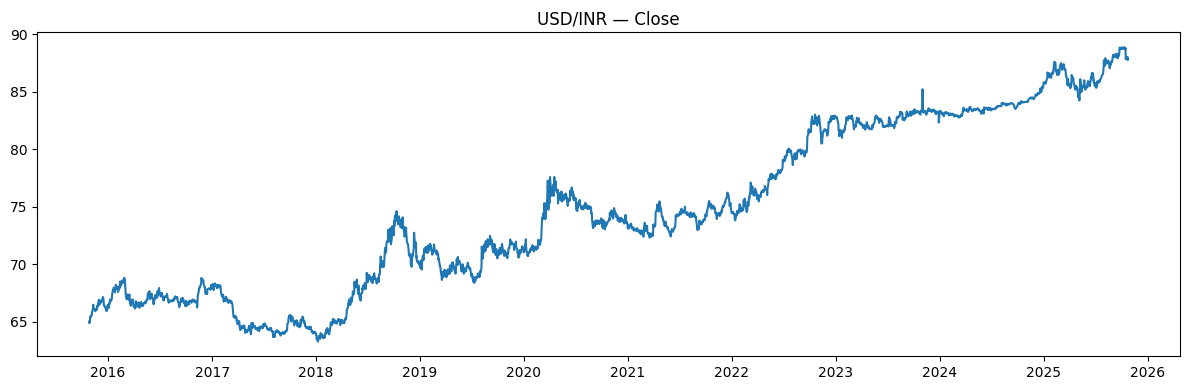

In [10]:
plt.figure(figsize=(12,4))
plt.plot(series)
plt.title("USD/INR — Close")
plt.tight_layout()
plt.show()

In [45]:
#adf test without fd
def adf_test(x, signif=0.05):
    res = adfuller(x, autolag='AIC')
    out = {
        "ADF Statistic": res[0],
        "p-value": res[1],
        "Used lags": res[2],
        "nobs": res[3],
        "Critical Values": res[4]
    }
    print(">>> ADF test")
    for k,v in out.items():
        print(f"{k}: {v}")
    if res[1] < signif:
        print("=> Reject H0 (series is likely stationary)")
    else:
        print("=> Fail to reject H0 (series is likely non-stationary)")
    print()

def kpss_test(x, signif=0.05, regression='c'):
    res = kpss(x, regression=regression, nlags="auto")
    out = {
        "KPSS Statistic": res[0],
        "p-value": res[1],
        "Used lags": res[2],
        "Critical Values": res[3]
    }
    print(">>> KPSS test (null: stationary)")
    for k,v in out.items():
        print(f"{k}: {v}")
    if res[1] < signif:
        print("=> Reject H0 (series is likely non-stationary)")
    else:
        print("=> Fail to reject H0 (series is likely stationary)")
    print()

print("Stationarity tests on original series:")



adf_test(series.dropna())
kpss_test(series.dropna())

Stationarity tests on original series:
>>> ADF test
ADF Statistic: -0.2114654927206787
p-value: 0.937141090422113
Used lags: 10
nobs: 2598
Critical Values: {'1%': np.float64(-3.4328695430687004), '5%': np.float64(-2.8626531392022194), '10%': np.float64(-2.5673625639785684)}
=> Fail to reject H0 (series is likely non-stationary)

>>> KPSS test (null: stationary)
KPSS Statistic: 8.048133678905463
p-value: 0.01
Used lags: 30
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
=> Reject H0 (series is likely non-stationary)



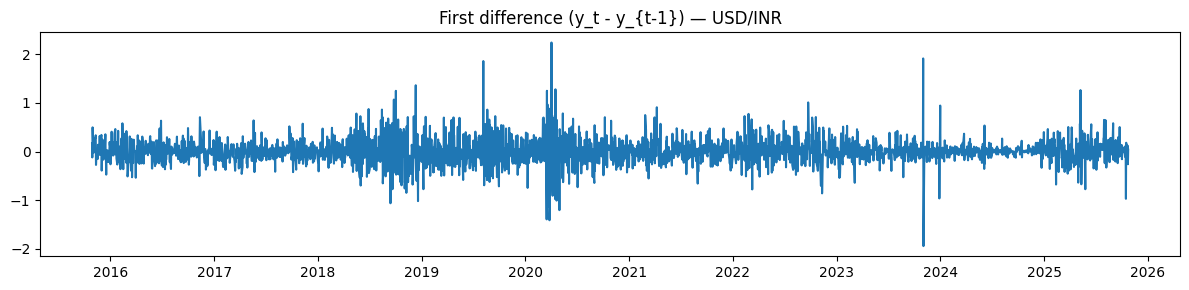

In [46]:
#fd
fd = series.diff().dropna()

plt.figure(figsize=(12,3))
plt.plot(fd)
plt.title("First difference (y_t - y_{t-1}) — USD/INR")
plt.tight_layout()
plt.show()

In [47]:
#adf test after fd
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(x, signif=0.05):
    """
    Augmented Dickey-Fuller Test
    H0: Series has a unit root (non-stationary)
    """
    x = x.dropna()
    res = adfuller(x, autolag='AIC')
    output = {
        "Test": "ADF",
        "ADF Statistic": res[0],
        "p-value": res[1],
        "Used Lags": res[2],
        "N Observations": res[3],
        "Critical Values": res[4]
    }

  
    print(">>> Augmented Dickey-Fuller (ADF) Test")
    for k, v in output.items():
        if k != "Critical Values":
            print(f"{k}: {v}")
    print("Critical Values:", output["Critical Values"])
    
    if res[1] < signif:
        print(f"=> Reject H₀ at {signif} level → Series is stationary")
    else:
        print(f"=> Fail to reject H₀ at {signif} level → Series is  non-stationary** ")
    print()

    return output


def kpss_test(x, signif=0.05, regression='c'):
    """
    KPSS Test
    H0: Series is stationary
    """
    x = x.dropna()
    res = kpss(x, regression=regression, nlags="auto")
    output = {
        "Test": "KPSS",
        "KPSS Statistic": res[0],
        "p-value": res[1],
        "Used Lags": res[2],
        "Critical Values": res[3]
    }
    print(f">>> KPSS Test (regression='{regression}')")
    for k, v in output.items():
        if k != "Critical Values":
            print(f"{k}: {v}")
    print("Critical Values:", output["Critical Values"])
    
    if res[1] < signif:
        print(f"=> Reject H₀ at {signif} level → Series is **likely non-stationary** ")
    else:
        print(f"=> Fail to reject H₀ at {signif} level → Series is stationary ")
    print()

    return output

adf_res = adf_test(fd)
kpss_res = kpss_test(fd)


>>> Augmented Dickey-Fuller (ADF) Test
Test: ADF
ADF Statistic: -15.558783776277751
p-value: 2.0551961725812493e-28
Used Lags: 9
N Observations: 2598
Critical Values: {'1%': np.float64(-3.4328695430687004), '5%': np.float64(-2.8626531392022194), '10%': np.float64(-2.5673625639785684)}
=> Reject H₀ at 0.05 level → Series is stationary

>>> KPSS Test (regression='c')
Test: KPSS
KPSS Statistic: 0.05257319530158344
p-value: 0.1
Used Lags: 4
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
=> Fail to reject H₀ at 0.05 level → Series is stationary 



series is stationary

<Figure size 1200x300 with 0 Axes>

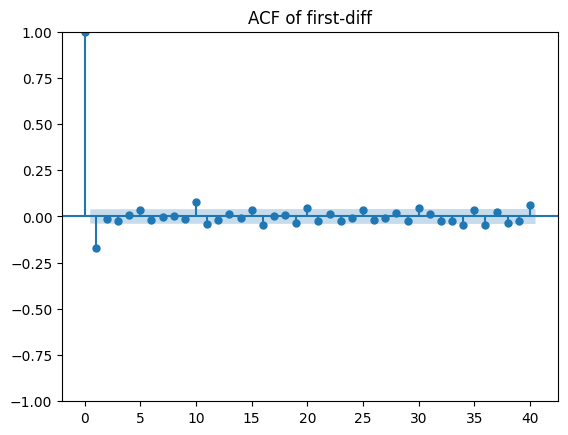

In [48]:
# ACF / PACF 
plt.figure(figsize=(12,3))
plot_acf(fd, lags=40, alpha=0.05)
plt.title("ACF of first-diff")
plt.show()


<Figure size 1200x300 with 0 Axes>

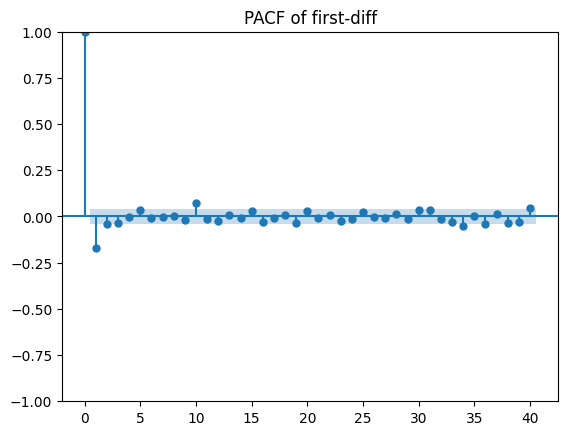

In [49]:

plt.figure(figsize=(12,3))
plot_pacf(fd, lags=40, method='ywm', alpha=0.05)
plt.title("PACF of first-diff")
plt.show()

What ACF Shows
Lag 1 (the first bar)
There’s a strong negative spike at lag 1 (around -0.25).
→ This means the first-differenced series has a negative autocorrelation between consecutive values.
→ Typical of a random walk after differencing — the series overshoots slightly from one step to the next.

Lags > 1

Beyond lag 1, all bars lie within the confidence bands (the shaded region).
→ This means no significant autocorrelation at higher lags.
→ The series behaves like white noise — random, unpredictable fluctuations.
p = 0 → No AR terms (ACF doesn’t show persistence)

d = 1 → First differencing (as confirmed)

q = 1 → One MA term (ACF cuts off after lag 1)


ACF: Shows a significant spike at lag 1 (negative) and cuts off quickly afterwards. There's maybe a small marginally significant spike around lag 10, but the rest are within the confidence band. This pattern (cutoff after lag 1) is suggestive of an MA(1) process.
PACF: Also shows a significant spike at lag 1 (negative) and cuts off quickly. Again, a small spike around lag 10. This pattern (cutoff after lag 1) is suggestive of an AR(1) process.
Combined: When both ACF and PACF cut off sharply after lag 1, it often indicates that the first-differenced series is stationary. The significant spike at lag 1 in both could suggest either an AR(1), MA(1), or mixed ARMA(1,1) model for the differenced series.
 

log

In [16]:
series = df["Close"].asfreq("B")
series = series.interpolate(method="time")

# log transform
log_y = np.log(series)


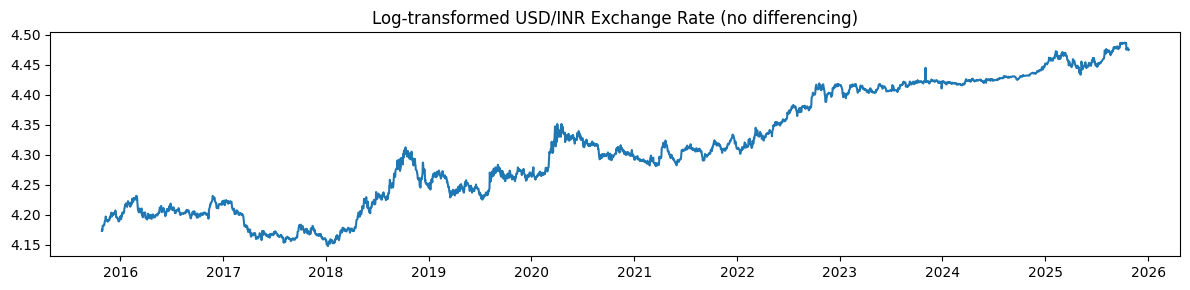

In [17]:
plt.figure(figsize=(12,3))
plt.plot(log_y)
plt.title("Log-transformed USD/INR Exchange Rate (no differencing)")
plt.tight_layout()
plt.show()

In [18]:
#adf test after log
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(x, signif=0.05):
    """
    Augmented Dickey-Fuller Test
    H0: Series has a unit root (non-stationary)
    """
    x = x.dropna()
    res = adfuller(x, autolag='AIC')
    output = {
        "Test": "ADF",
        "ADF Statistic": res[0],
        "p-value": res[1],
        "Used Lags": res[2],
        "N Observations": res[3],
        "Critical Values": res[4]
    }

  
    print(">>> Augmented Dickey-Fuller (ADF) Test")
    for k, v in output.items():
        if k != "Critical Values":
            print(f"{k}: {v}")
    print("Critical Values:", output["Critical Values"])
    
    if res[1] < signif:
        print(f"=> Reject H₀ at {signif} level → Series is stationary")
    else:
        print(f"=> Fail to reject H₀ at {signif} level → Series is  non-stationary** ")
    print()

    return output




def kpss_test(x, signif=0.05, regression='c'):
    """
    KPSS Test
    H0: Series is stationary
    """
    x = x.dropna()
    res = kpss(x, regression=regression, nlags="auto")
    output = {
        "Test": "KPSS",
        "KPSS Statistic": res[0],
        "p-value": res[1],
        "Used Lags": res[2],
        "Critical Values": res[3]
    }
    print(f">>> KPSS Test (regression='{regression}')")
    for k, v in output.items():
        if k != "Critical Values":
            print(f"{k}: {v}")
    print("Critical Values:", output["Critical Values"])
    
    if res[1] < signif:
        print(f"=> Reject H₀ at {signif} level → Series is **likely non-stationary** ")
    else:
        print(f"=> Fail to reject H₀ at {signif} level → Series is stationary ")
    print()

    return output

adf_res = adf_test(log_y)
kpss_res = kpss_test(log_y)


>>> Augmented Dickey-Fuller (ADF) Test
Test: ADF
ADF Statistic: -0.3540333169077805
p-value: 0.9174953155103163
Used Lags: 10
N Observations: 2598
Critical Values: {'1%': np.float64(-3.4328695430687004), '5%': np.float64(-2.8626531392022194), '10%': np.float64(-2.5673625639785684)}
=> Fail to reject H₀ at 0.05 level → Series is  non-stationary** 

>>> KPSS Test (regression='c')
Test: KPSS
KPSS Statistic: 8.050069864730299
p-value: 0.01
Used Lags: 30
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
=> Reject H₀ at 0.05 level → Series is **likely non-stationary** 



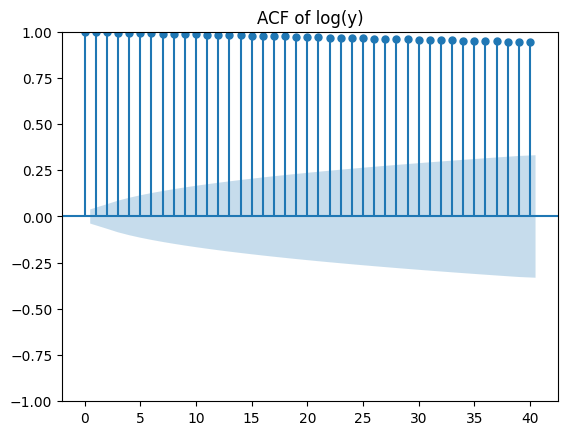

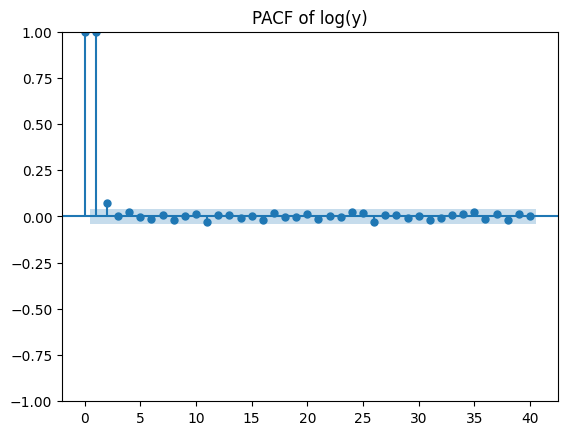

In [19]:
plot_acf(log_y.dropna(), lags=40)
plt.title("ACF of log(y)")
plt.show()

plot_pacf(log_y.dropna(), lags=40, method='ywm')
plt.title("PACF of log(y)")
plt.show()

Both tests agree the log-transformed series is still non-stationary.
The log transform stabilizes variance (i.e., reduces exponential growth), but not mean. So, differencing is still needed.

ACF:

High correlations close to 1 for many lags, only slowly declining → strong persistence, typical of non-stationary or trend-dominated series.

PACF:

The first two lags are near 1, after which correlations drop sharply and lie within the confidence bounds.

This pattern indicates that the non-stationarity is largely due to a trend (not seasonal) component, which can usually be removed by first differencing.


log fd

In [50]:
log_y = np.log(series)
log_fd = log_y.diff().dropna()


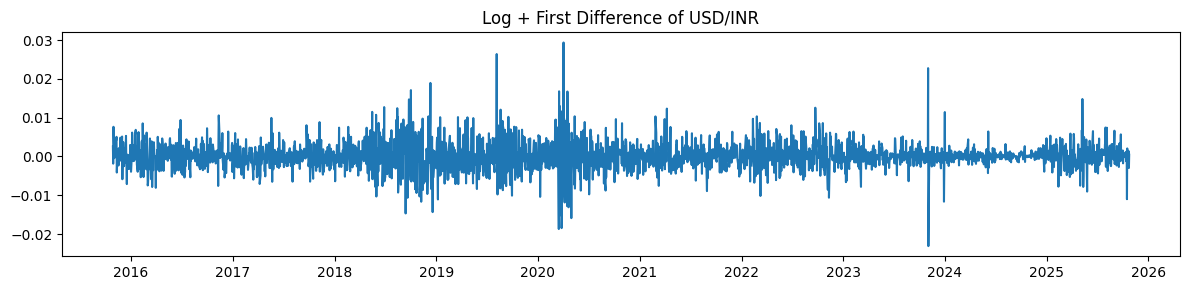

In [51]:
plt.figure(figsize=(12,3))
plt.plot(log_fd)
plt.title("Log + First Difference of USD/INR")
plt.tight_layout()
plt.show()


In [52]:
#adf test after fd+log
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(x, signif=0.05):
    """
    Augmented Dickey-Fuller Test
    H0: Series has a unit root (non-stationary)
    """
    x = x.dropna()
    res = adfuller(x, autolag='AIC')
    output = {
        "Test": "ADF",
        "ADF Statistic": res[0],
        "p-value": res[1],
        "Used Lags": res[2],
        "N Observations": res[3],
        "Critical Values": res[4]
    }

  
    print(">>> Augmented Dickey-Fuller (ADF) Test")
    for k, v in output.items():
        if k != "Critical Values":
            print(f"{k}: {v}")
    print("Critical Values:", output["Critical Values"])
    
    if res[1] < signif:
        print(f"=> Reject H₀ at {signif} level → Series is stationary")
    else:
        print(f"=> Fail to reject H₀ at {signif} level → Series is  non-stationary** ")
    print()

    return output




def kpss_test(x, signif=0.05, regression='c'):
    """
    KPSS Test
    H0: Series is stationary
    """
    x = x.dropna()
    res = kpss(x, regression=regression, nlags="auto")
    output = {
        "Test": "KPSS",
        "KPSS Statistic": res[0],
        "p-value": res[1],
        "Used Lags": res[2],
        "Critical Values": res[3]
    }
    print(f">>> KPSS Test (regression='{regression}')")
    for k, v in output.items():
        if k != "Critical Values":
            print(f"{k}: {v}")
    print("Critical Values:", output["Critical Values"])
    
    if res[1] < signif:
        print(f"=> Reject H₀ at {signif} level → Series is **likely non-stationary** ")
    else:
        print(f"=> Fail to reject H₀ at {signif} level → Series is stationary ")
    print()

    return output

adf_res = adf_test(log_fd)
kpss_res = kpss_test(log_fd)


>>> Augmented Dickey-Fuller (ADF) Test
Test: ADF
ADF Statistic: -15.556014194291285
p-value: 2.0710572009155575e-28
Used Lags: 9
N Observations: 2598
Critical Values: {'1%': np.float64(-3.4328695430687004), '5%': np.float64(-2.8626531392022194), '10%': np.float64(-2.5673625639785684)}
=> Reject H₀ at 0.05 level → Series is stationary

>>> KPSS Test (regression='c')
Test: KPSS
KPSS Statistic: 0.03979648514676277
p-value: 0.1
Used Lags: 3
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
=> Fail to reject H₀ at 0.05 level → Series is stationary 



==> stationarry series

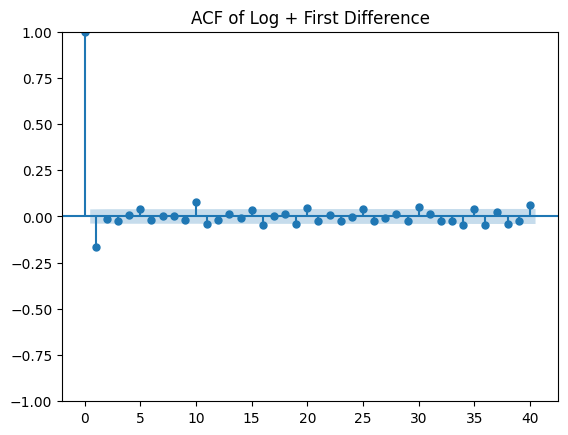

In [55]:
#ACF / PACF 
plot_acf(log_fd, lags=40)
plt.title("ACF of Log + First Difference")
plt.show()


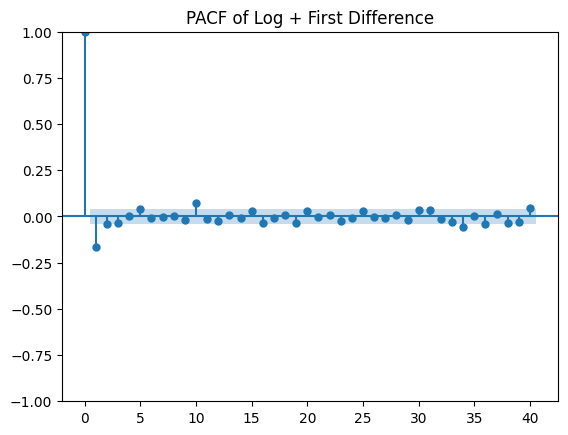

In [56]:

plot_pacf(log_fd, lags=40, method='ywm')
plt.title("PACF of Log + First Difference")
plt.show()

Log + First Difference approach is generally a safer and more robust choice as it handles both non-stationarity in mean (via differencing) and potentially non-stationarity in variance (via the log transform).

In [ ]:
seasonality +seasonality decomposition

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp=seasonal_decompose(log_fd.dropna(),model='additive',period=252)

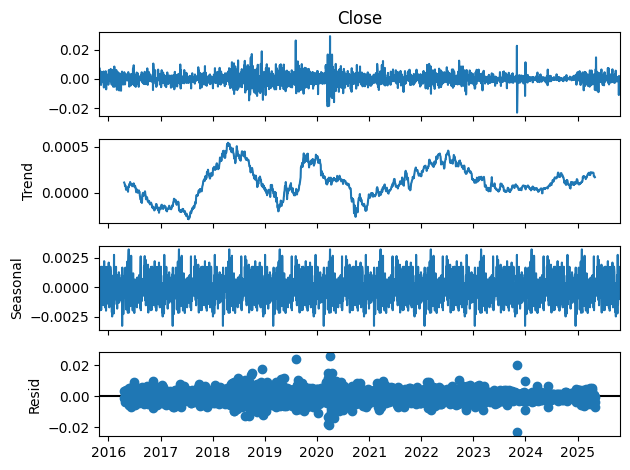

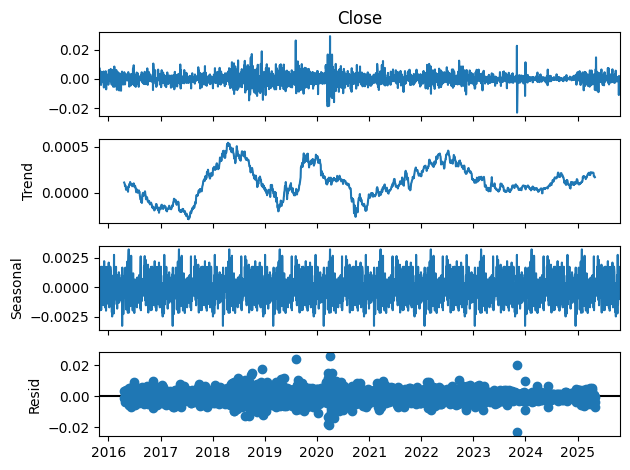

In [60]:
decomp.plot()

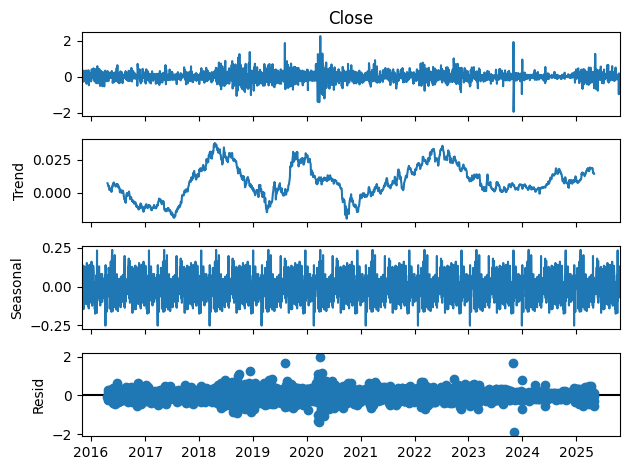

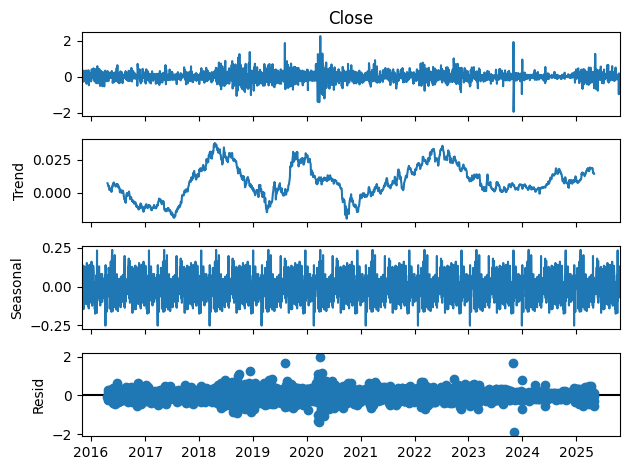

In [86]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(fd.dropna(), model='additive', period=252)  # yearly seasonality
decomp.plot()


Original Series: Fluctuates around zero with varying volatility (spikes seem larger around 2020). This represents  differenced data not raw prices.
Trend Component: Shows a clear, slow-moving, cyclical pattern over the years, though the magnitude (scale on the y-axis) is very small.
Seasonal Component: Exhibits a regular, high-frequency pattern, indicating consistent short-term seasonality. The magnitude of this component is also relatively small compared to the original series' noise.
Residual Component: Mostly appears random and centered around zero, but with noticeable clusters of larger residuals (especially around 2020), suggesting periods of higher unexplained volatility or noise.


Likely Stationarity (in Mean): Since the original series seems to fluctuate around a constant level (zero), and the trend component's magnitude is very small relative to the residuals, the series might be considered mean-stationary or close to it 

Presence of Weak Trend/Cycles: While potentially mean-stationary, the decomposition did extract a discernible long-term trend/cyclical component. Although small, this suggests some underlying slow-moving dynamics might still be present.

Presence of Seasonality: The clear pattern in the seasonal component confirms that there are predictable short-term fluctuations within the data that repeat regularly.

Volatility Clustering: The residual plot shows that the random noise is not constant over time. The periods of larger residuals (like 2020) indicate volatility clustering, a common phenomenon in financial time series where periods of high fluctuation are followed by more high fluctuation, and periods of calm are followed by calm. 

Decomposition Success: The decomposition appears somewhat successful in separating the components. The residuals look mostly random, implying that the trend and seasonal components have captured systematic patterns.
 However, the non-constant variance in the residuals suggests that the basic additive/multiplicative decomposition model might not capture everything (especially the changing volatility).
Overall: The time series (likely representing returns) appears largely stationary in the mean but contains weak long-term cycles, clear short-term seasonality, and periods of changing volatility (heteroscedasticity).
 Models chosen should account for seasonality (e.g., SARIMA) and potentially the changing volatility (e.g., GARCH if modeling the residuals).

#models


train test split

In [59]:
df

,Close,daily_diff
Date,,
2015-10-27,64.901001,NaN
2015-10-28,65.067001,64.901001
2015-10-29,64.945999,65.067001
2015-10-30,65.444000,64.945999
2015-11-02,65.415001,65.444000
...,...,...
2025-10-20,88.002296,87.990700
2025-10-21,87.879997,88.002296
2025-10-22,88.001602,87.879997


In [28]:
train_size = int(len(df) * 0.8)
train = df['daily_diff'][:train_size]
test = df['daily_diff'][train_size:]

In [33]:
from statsmodels.tsa.arima.model import ARIMA

In [34]:
model=ARIMA(train,order=(1,1,0))
model_fit=model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             daily_diff   No. Observations:                 2082
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -298.727
Date:                Thu, 30 Oct 2025   AIC                            601.455
Time:                        00:14:45   BIC                            612.736
Sample:                             0   HQIC                           605.588
                               - 2082                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1537      0.015    -10.532      0.000      -0.182      -0.125
sigma2         0.0774      0.001     60.348      0.000       0.075       0.080
Ljung-Box (L1) (Q):                   0.09   Jarque-

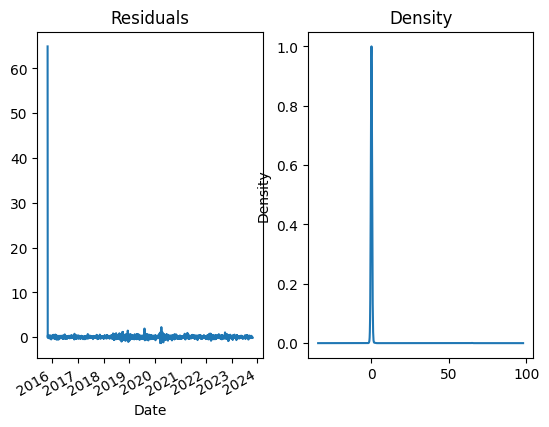

In [ ]:
#preds
residuals=model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()



<Axes: xlabel='Date'>

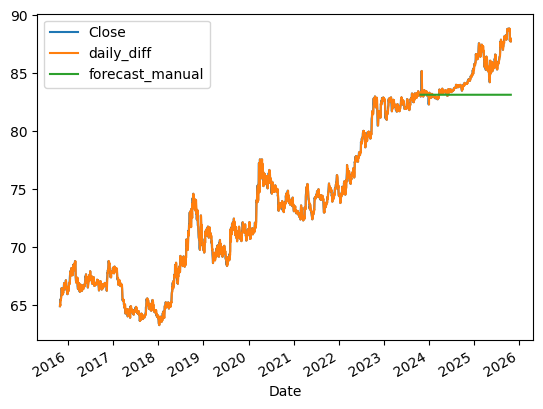

In [36]:
forecast_test = model_fit.forecast(len(test))

df['forecast_manual'] = [None]*len(train) + list(forecast_test)

df.plot()

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

# Grid search over possible values of p, d, q
p_values = range(0, 4)  # Try p from 0 to 3
d_values = range(0, 2)  # Try d from 0 to 1
q_values = range(0, 4)  # Try q from 0 to 3


pdq_combinations = list(product(p_values, d_values, q_values))

best_aic = np.inf
best_order = None
best_model = None

for order in pdq_combinations:
    try:
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_order = order
            best_model = model_fit
    except Exception as e:
        print(f"Error with order {order}: {e}")
        
print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")


Best ARIMA order: (3, 1, 2) with AIC: 578.9926394365419


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
p_values = range(0, 6)  
d_values = range(0, 1)  
q_values = range(0, 6)  

pdq_combinations = list(product(p_values, d_values, q_values))

best_aic = np.inf
best_order = None
best_model = None

for order in pdq_combinations:
    try:
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_order = order
            best_model = model_fit
    except Exception as e:
        
        print(f"Error with order {order}: {e}")
        
print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")


Best ARIMA order: (4, 0, 4) with AIC: 579.651711630522


                               SARIMAX Results                                
Dep. Variable:             daily_diff   No. Observations:                 2082
Model:                          ARIMA   Log Likelihood               -6556.838
Date:                Thu, 30 Oct 2025   AIC                          13117.676
Time:                        05:51:05   BIC                          13128.958
Sample:                             0   HQIC                         13121.810
                               - 2082                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.1696      0.133    540.634      0.000      71.908      72.431
sigma2        31.9364      1.390     22.975      0.000      29.212      34.661
Ljung-Box (L1) (Q):                2074.42   Jarque-

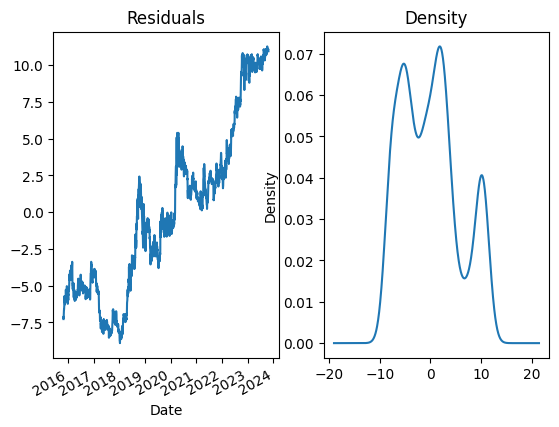

<Axes: xlabel='Date'>

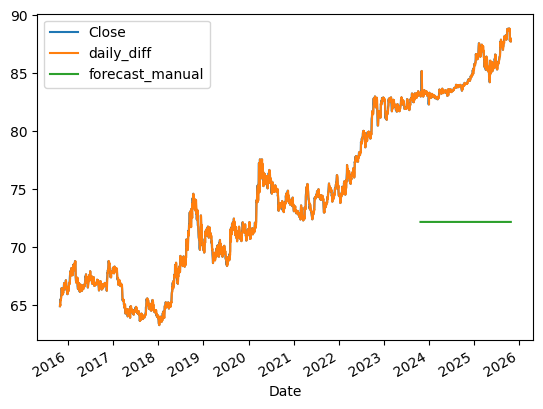

In [62]:
model=ARIMA(train,order=(0,0,0))
model_fit=model.fit()
print(model_fit.summary())
#preds

residuals=model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

forecast_test = model_fit.forecast(len(test))

df['forecast_manual'] = [None]*len(train) + list(forecast_test)

df.plot()

                               SARIMAX Results                                
Dep. Variable:             daily_diff   No. Observations:                 2082
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -318.918
Date:                Thu, 30 Oct 2025   AIC                            643.836
Time:                        05:51:19   BIC                            660.760
Sample:                             0   HQIC                           650.038
                               - 2082                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.1696      5.634     12.810      0.000      61.128      83.211
ar.L1          0.9993      0.001    724.811      0.000       0.997       1.002
sigma2         0.0793      0.001     59.330      0.0

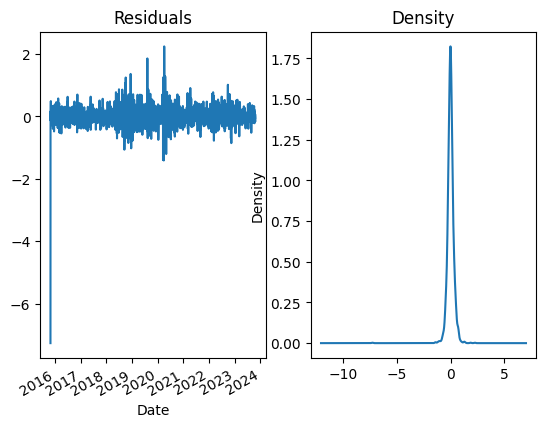

<Axes: xlabel='Date'>

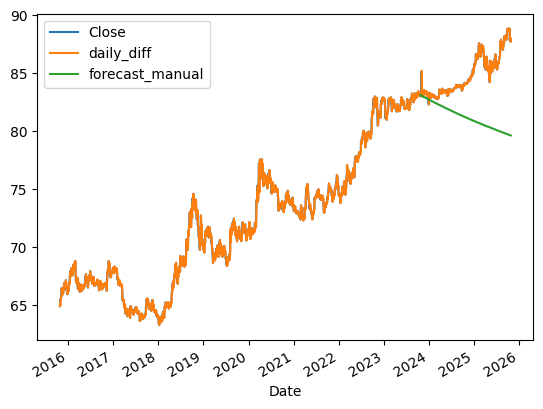

In [63]:
model=ARIMA(train,order=(1,0,0))
model_fit=model.fit()
print(model_fit.summary())
#preds

residuals=model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

forecast_test = model_fit.forecast(len(test))

df['forecast_manual'] = [None]*len(train) + list(forecast_test)

df.plot()

                               SARIMAX Results                                
Dep. Variable:             daily_diff   No. Observations:                 2082
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -5203.087
Date:                Thu, 30 Oct 2025   AIC                          10412.174
Time:                        05:51:37   BIC                          10429.098
Sample:                             0   HQIC                         10418.376
                               - 2082                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.1705      0.136    530.091      0.000      71.904      72.437
ma.L1          0.9579      0.007    134.200      0.000       0.944       0.972
sigma2         8.6839      0.377     23.041      0.0

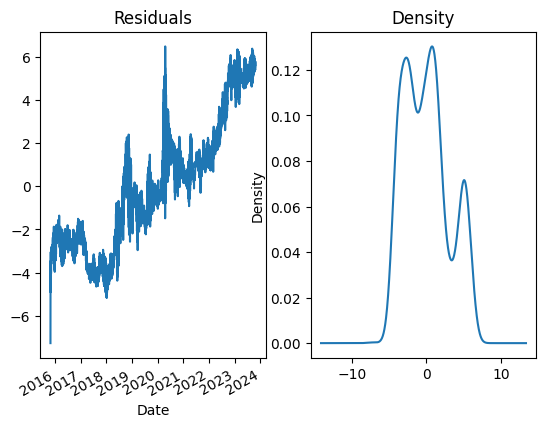

<Axes: xlabel='Date'>

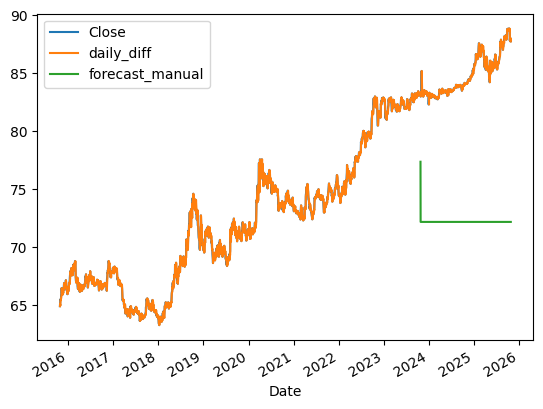

In [64]:
model=ARIMA(train,order=(0,0,1))
model_fit=model.fit()
print(model_fit.summary())
#preds

residuals=model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

forecast_test = model_fit.forecast(len(test))

df['forecast_manual'] = [None]*len(train) + list(forecast_test)

df.plot()

                               SARIMAX Results                                
Dep. Variable:             daily_diff   No. Observations:                 2082
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -318.918
Date:                Thu, 30 Oct 2025   AIC                            643.836
Time:                        05:53:33   BIC                            660.760
Sample:                             0   HQIC                           650.038
                               - 2082                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.1696      5.634     12.810      0.000      61.128      83.211
ar.L1          0.9993      0.001    724.811      0.000       0.997       1.002
sigma2         0.0793      0.001     59.330      0.0

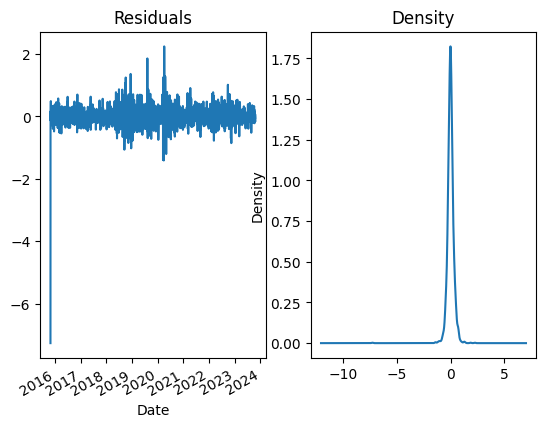

<Axes: xlabel='Date'>

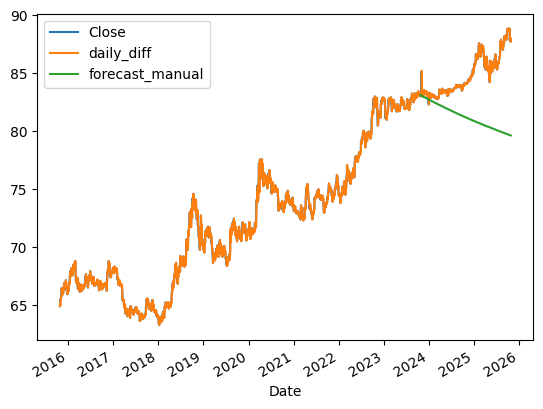

In [65]:
model=ARIMA(train,order=(1,0,0))
model_fit=model.fit()
print(model_fit.summary())
#preds

residuals=model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

forecast_test = model_fit.forecast(len(test))

df['forecast_manual'] = [None]*len(train) + list(forecast_test)

df.plot()

                               SARIMAX Results                                
Dep. Variable:             daily_diff   No. Observations:                 2082
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -297.359
Date:                Thu, 30 Oct 2025   AIC                            598.718
Time:                        05:53:47   BIC                            609.999
Sample:                             0   HQIC                           602.852
                               - 2082                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1626      0.015    -10.763      0.000      -0.192      -0.133
sigma2         0.0773      0.001     60.265      0.000       0.075       0.080
Ljung-Box (L1) (Q):                   0.00   Jarque-

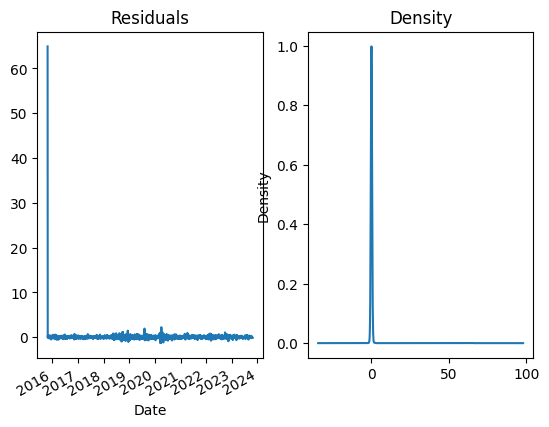

<Axes: xlabel='Date'>

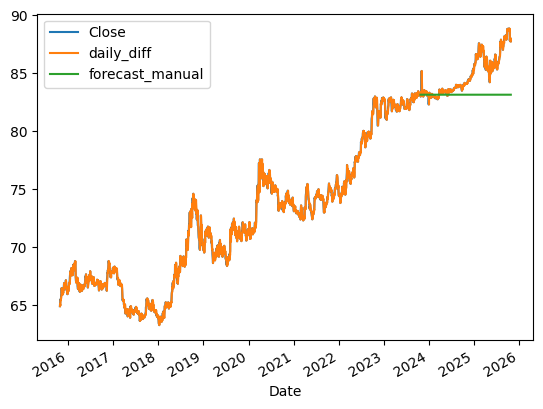

In [66]:
model=ARIMA(train,order=(0,1,1))
model_fit=model.fit()
print(model_fit.summary())
#preds

residuals=model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

forecast_test = model_fit.forecast(len(test))

df['forecast_manual'] = [None]*len(train) + list(forecast_test)

df.plot()

                               SARIMAX Results                                
Dep. Variable:             daily_diff   No. Observations:                 2082
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -298.727
Date:                Thu, 30 Oct 2025   AIC                            601.455
Time:                        05:54:01   BIC                            612.736
Sample:                             0   HQIC                           605.588
                               - 2082                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1537      0.015    -10.532      0.000      -0.182      -0.125
sigma2         0.0774      0.001     60.348      0.000       0.075       0.080
Ljung-Box (L1) (Q):                   0.09   Jarque-

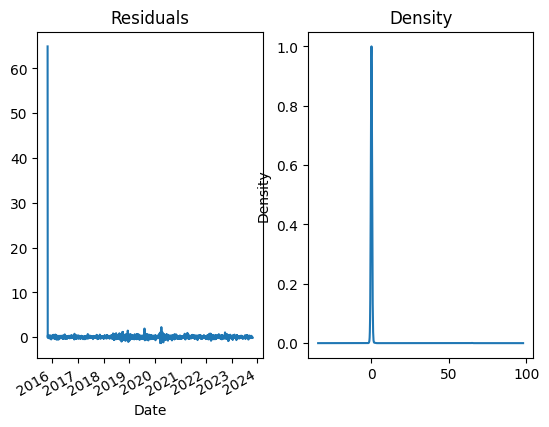

<Axes: xlabel='Date'>

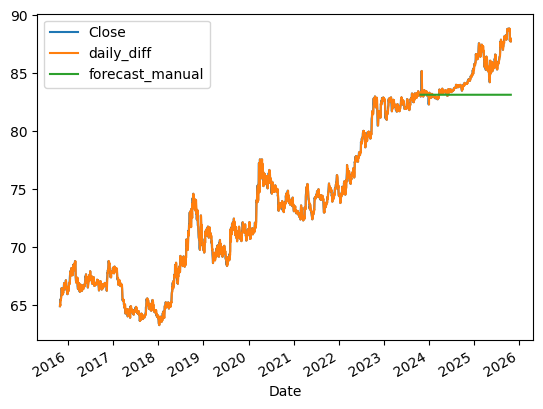

In [67]:
model=ARIMA(train,order=(1,1,0))
model_fit=model.fit()
print(model_fit.summary())
#preds

residuals=model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

forecast_test = model_fit.forecast(len(test))

df['forecast_manual'] = [None]*len(train) + list(forecast_test)

df.plot()

In [82]:
models_to_test = [
    (0,0,0),   # AR(0)
    (1,0,0),   # AR(1)
    (0,0,1),   # MA(1)
    (1,0,1),   # ARMA(1,1)
    (0,1,1),   # ARIMA(0,1,1)
    (1,1,0),   # ARIMA(1,1,0)
    (1,1,1),
    (2,1,1),
    (2,1,2),
    (1,1,2),
    (3,1,1),
    (3,1,3),
    (1,1,3),
    (3,1,2),
    (2,1,3),
    (4,1,1),
    (4,1,2),
    (4,1,3),
    (4,1,4),
    (1,1,4),
    (5,1,1),
    (5,1,2),
    (5,1,3),
    (5,1,4),
    (5,1,5),
    (1,1,5),
    (2,1,5),
    (3,1,5),
    (4,1,5),
    (5,1,5)
    

]

results = []

In [77]:
from statsmodels.tools.eval_measures import mse, meanabs

rmse = np.sqrt(mse(test, forecast))
mae = meanabs(test, forecast)


In [83]:
from statsmodels.tools.eval_measures import mse,meanabs
from sklearn.metrics import mean_squared_error, mean_absolute_error


for order in models_to_test:
    try:
        model = ARIMA(train, order=order)
        fitted = model.fit()
        
        # Forecast
        forecast = fitted.forecast(steps=len(test))
        
        # Compute metrics
        rmse = np.sqrt(mean_squared_error(test, forecast))
        mae = mean_absolute_error(test, forecast)
        
        results.append({
            'Model': f'ARIMA{order}',
            'AIC': fitted.aic,
            'BIC': fitted.bic,
            'RMSE': rmse,
            'MAE': mae
        })
        
        print(f"ARIMA{order}:")
        print(f"  AIC: {fitted.aic:.2f}")
        print(f"  BIC: {fitted.bic:.2f}")
        print(f"  RMSE: {rmse:.6f}")
        print(f"  MAE: {mae:.6f}\n")
        
    except Exception as e:
        print(f"ARIMA{order}: Failed - {e}\n")

ARIMA(0, 0, 0):
  AIC: 13117.68
  BIC: 13128.96
  RMSE: 12.775658
  MAE: 12.661093

ARIMA(1, 0, 0):
  AIC: 643.84
  BIC: 660.76
  RMSE: 4.440756
  MAE: 3.573464

ARIMA(0, 0, 1):
  AIC: 10412.17
  BIC: 10429.10
  RMSE: 12.768248
  MAE: 12.650260

ARIMA(1, 0, 1):
  AIC: 593.79
  BIC: 616.36
  RMSE: 3.407270
  MAE: 2.620340

ARIMA(0, 1, 1):
  AIC: 598.72
  BIC: 610.00
  RMSE: 2.398567
  MAE: 1.724517

ARIMA(1, 1, 0):
  AIC: 601.45
  BIC: 612.74
  RMSE: 2.401354
  MAE: 1.727578

ARIMA(1, 1, 1):
  AIC: 599.96
  BIC: 616.89
  RMSE: 2.396946
  MAE: 1.722754

ARIMA(2, 1, 1):
  AIC: 604.98
  BIC: 627.54
  RMSE: 1.378630
  MAE: 0.941319

ARIMA(2, 1, 2):
  AIC: 603.43
  BIC: 631.64
  RMSE: 2.396788
  MAE: 1.722579

ARIMA(1, 1, 2):
  AIC: 601.89
  BIC: 624.45
  RMSE: 2.396768
  MAE: 1.722559

ARIMA(3, 1, 1):
  AIC: 602.57
  BIC: 630.77
  RMSE: 2.396907
  MAE: 1.722712

ARIMA(3, 1, 3):
  AIC: 580.94
  BIC: 620.42
  RMSE: 2.389030
  MAE: 1.714270

ARIMA(1, 1, 3):
  AIC: 602.93
  BIC: 631.13
  RMSE: 

In [ ]:
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df.sort_values(by="AIC"))

best_model_order = results_df.loc[results_df['AIC'].idxmin(), 'Model']
print(f"\nBest model based on AIC: {best_model_order}")


Model Comparison:
             Model           AIC           BIC       RMSE        MAE
13  ARIMA(3, 1, 2)    578.992639    612.836262   2.388373   1.713738
17  ARIMA(4, 1, 3)    580.657638    625.782468   2.385984   1.711110
11  ARIMA(3, 1, 3)    580.940508    620.424735   2.389030   1.714270
28  ARIMA(4, 1, 5)    581.459076    637.865114   2.391366   1.716668
22  ARIMA(5, 1, 3)    587.011040    637.776475   2.388668   1.713966
24  ARIMA(5, 1, 5)    590.049356    652.095998   2.388953   1.714110
29  ARIMA(5, 1, 5)    590.049356    652.095998   2.388953   1.714110
27  ARIMA(3, 1, 5)    592.799677    643.565112   1.355372   0.942907
3   ARIMA(1, 0, 1)    593.791417    616.355754   3.407270   2.620340
23  ARIMA(5, 1, 4)    594.308867    650.714905   2.405070   1.731649
14  ARIMA(2, 1, 3)    596.038208    629.881831   2.391194   1.716497
4   ARIMA(0, 1, 1)    598.718200    609.999408   2.398567   1.724517
18  ARIMA(4, 1, 4)    599.358500    650.123935   2.398107   1.724095
6   ARIMA(1, 1,

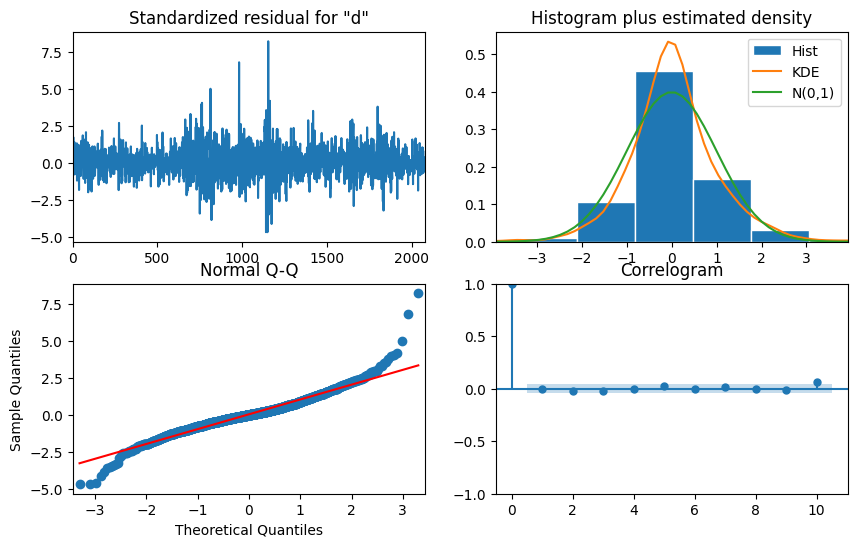

In [85]:
best = ARIMA(train, order=(3,1,2)).fit()
best.plot_diagnostics(figsize=(10,6))
plt.show()
